# **Intro**  
Dataset:
https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals/data  

5400 Animal Images in 90 different categories

# **Training the model**

## Imports

In [76]:
import pickle

In [1]:
import itertools
import os

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img  # pip install pillow, then restart the kernel
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score , confusion_matrix

# Pretrained cnn
from keras.applications.imagenet_utils import decode_predictions

# if you use tensorflow.keras: 
from efficientnet.tfkeras import EfficientNetB0, EfficientNetB3
from efficientnet.tfkeras import center_crop_and_resize, preprocess_input

**VARIABLES**

In [3]:
SMALL_IMAGE_SIZE = 150  # 224 takes more to train, so train on smaller images
LARGE_IMAGE_SIZE = 224  # Size that the base model has as default input size
NUM_CLASSES = 90 # 90 animals in ghe dataset

## Raw sample image

In [5]:
path = "./img/animals/antelope/"
name = "61c60311b5.jpg"
full_name = f'{path}/{name}'

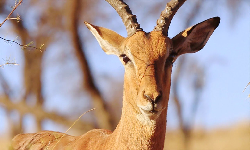

In [6]:
load_img(full_name, target_size=(150, 250))

## Full dataset

In [4]:
path = "./img/animals/"

In [5]:
data = {"path": [] , "label": [] }
categories = os.listdir(path)
for folder in categories:
    folder_path = os.path.join(path , folder)
    files = os.listdir(folder_path)
    for file in files:
        fpath = os.path.join(folder_path, file)
        data["path"].append(fpath)
        data["label"].append(folder)

df = pd.DataFrame(data) 

# Encode labels
lbl_encoder = LabelEncoder()
df['encoded_label'] = lbl_encoder.fit_transform(df['label'])

In [6]:
df.sample(3)

,path,label,encoded_label
4290,./img/animals/sandpiper\4aa6c0cc2d.jpg,sandpiper,71
2477,./img/animals/jellyfish\3b48327f79.jpg,jellyfish,41
3396,./img/animals/owl\6d8c9d7ab1.jpg,owl,56


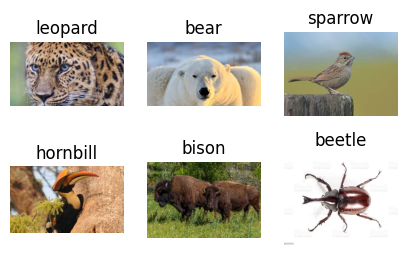

In [7]:
plt.figure(figsize=(5,3))
for i, row in df.sample(n=6).reset_index().iterrows():
    plt.subplot(2,3,i+1)
    image_path = row['path']
    #img = pil_image.open(image_path)
    img = load_img(image_path)
    plt.imshow(img)
    plt.title(row["label"])
    plt.axis('off')
plt.show()

## Pretrained CNN model (EfficientNet)  
Although Xception is a good Deep Learning architecture, [EfficientNet](https://pypi.org/project/efficientnet/) has become the go-to architecture for many challenging tasks, particularly in object recognition applications.  
  
See more: https://blog.roboflow.com/what-is-efficientnet/#:~:text=EfficientNet%20addresses%20this%20challenge%20by,of%20efficiency%20without%20compromising%20accuracy.  
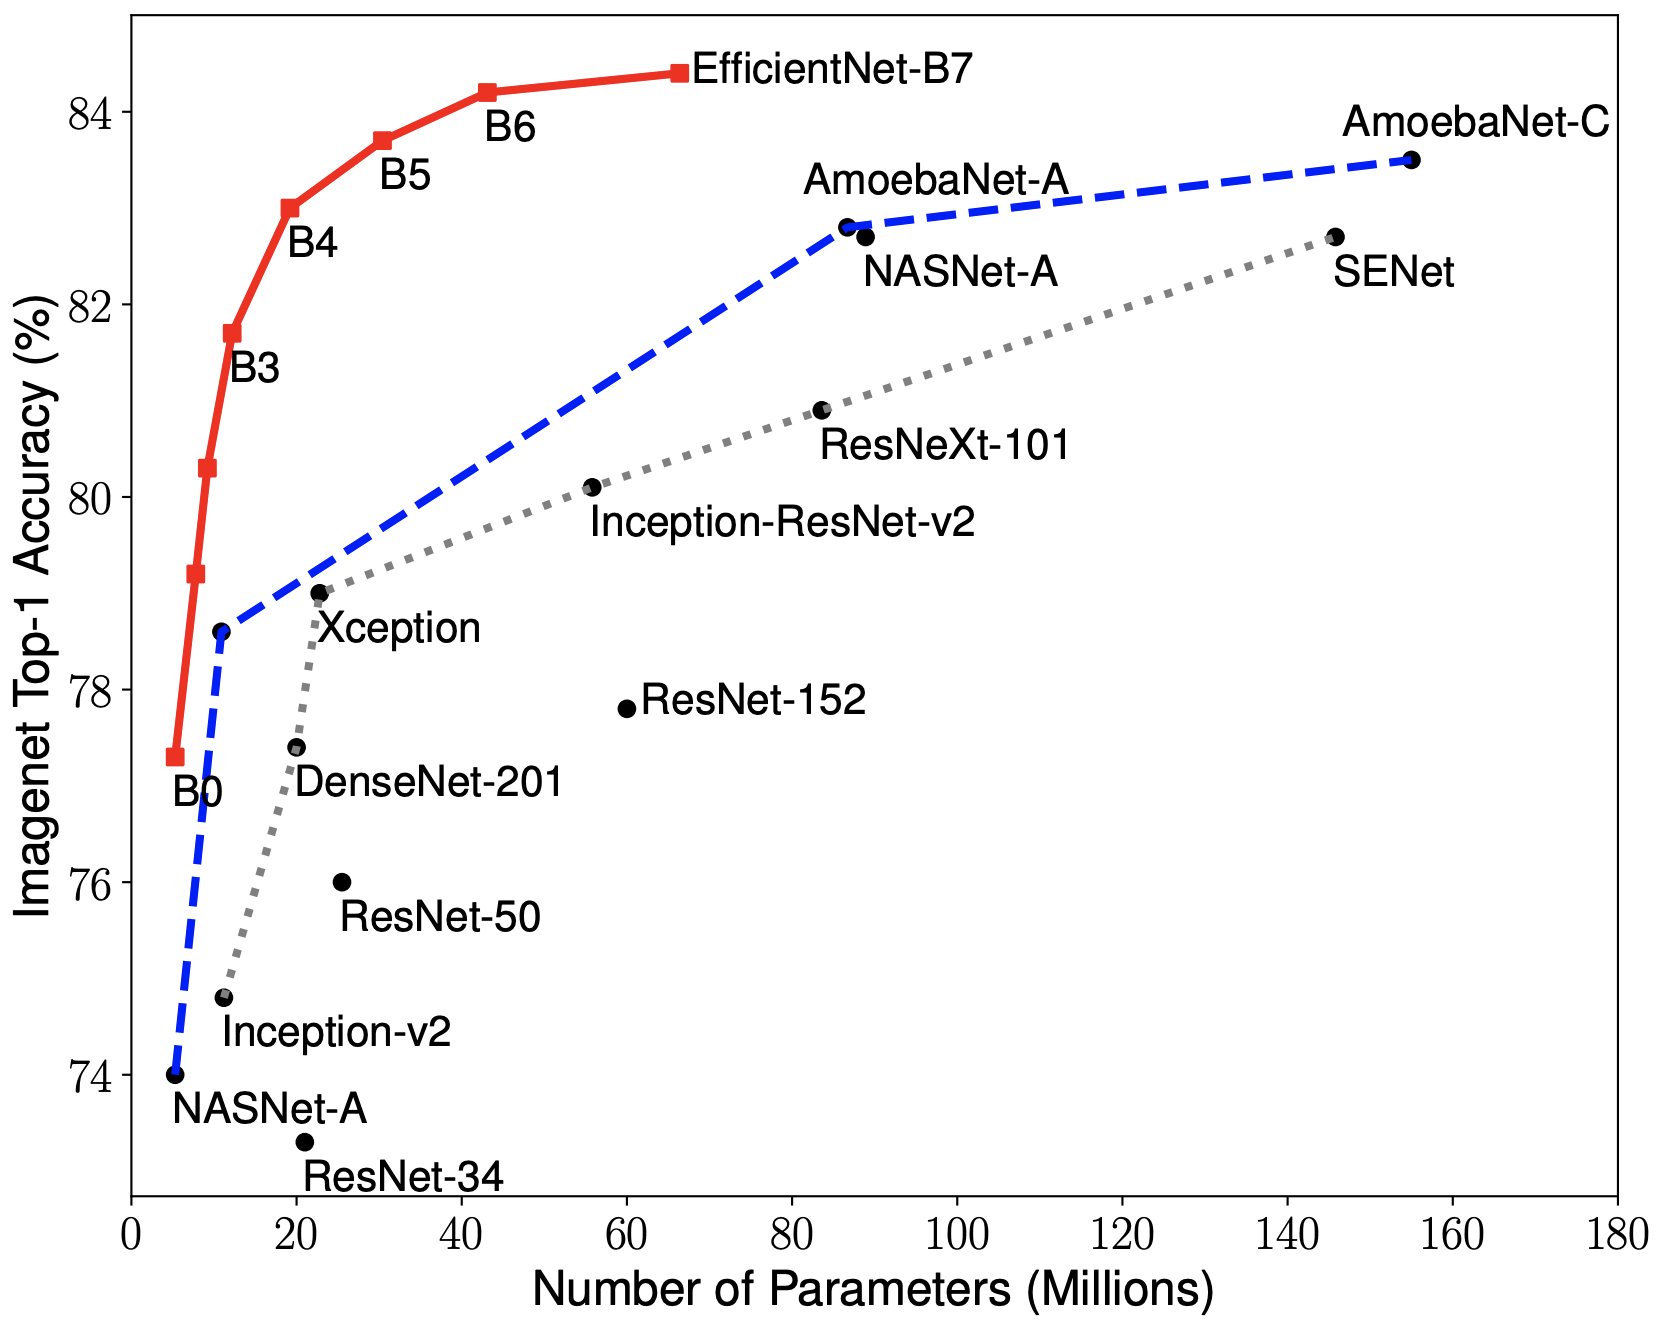

In [12]:
# loading pretrained model
EfficientNetB0_model = EfficientNetB0(weights='imagenet')

**Preprocess input**

In [13]:
EfficientNetB0_model_image_size = EfficientNetB0_model.input_shape[1]
EfficientNetB0_model_image_size

224

In [27]:
sample_animal = df.sample()
sample_image_full_path = sample_animal["path"].iloc[0]
sample_image_label = sample_animal["label"].iloc[0]

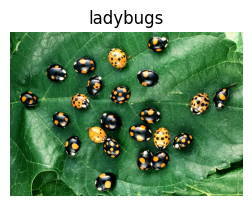

In [28]:
sample_img = imread(sample_image_full_path)
plt.figure(figsize=(3, 3))
plt.imshow(sample_img)
plt.title(sample_image_label)
plt.axis('off')
plt.show()


**Make prediciton and decode**

In [36]:
# With target_size = default size: 
x = center_crop_and_resize(sample_img, image_size=LARGE_IMAGE_SIZE)
X = preprocess_input(x)
X = np.expand_dims(X, 0)
pred = EfficientNetB0_model.predict(X)
decode_predictions(pred)

1/1 [==============================] - 0s 50ms/step


[[('n02165456', 'ladybug', 0.34174356),
  ('n07695742', 'pretzel', 0.06188221),
  ('n02169497', 'leaf_beetle', 0.06063268),
  ('n04254680', 'soccer_ball', 0.034168582),
  ('n01950731', 'sea_slug', 0.018746834)]]

In [37]:
# With target_size = base_size (150): 
x = center_crop_and_resize(sample_img, image_size=SMALL_IMAGE_SIZE)
X = preprocess_input(x)
X = np.expand_dims(X, 0)
pred = EfficientNetB0_model.predict(X)
decode_predictions(pred)

1/1 [==============================] - 0s 49ms/step


[[('n02165456', 'ladybug', 0.25020635),
  ('n02169497', 'leaf_beetle', 0.054889493),
  ('n07695742', 'pretzel', 0.02936726),
  ('n04525038', 'velvet', 0.028992891),
  ('n04136333', 'sarong', 0.024735538)]]

In [32]:
# The prediction probability does not change by much, and it's still accurate
# Also, notice that the prediction probabilities are not very high and there are
# classes other than animals

# We will extend this model training it with the animals dataset

## Train-Test splitting

In [8]:
train_df, tmp_df = train_test_split(df,  train_size= 0.60 , shuffle=True, random_state=0)
val_df , test_df = train_test_split(tmp_df ,  train_size= 0.50 , shuffle=True, random_state=0)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"Train ({train_df.shape[0]})")
print(train_df[["path", "label"]].head(3))

print(f"\nValidation ({val_df.shape[0]})")
print(val_df[["path", "label"]].head(3))

print(f"\nTest ({test_df.shape[0]})")
print(test_df[["path", "label"]].head(3))

Train (3240)
                                   path    label
0      ./img/animals/cat\6edc079fcf.jpg      cat
1  ./img/animals/lobster\f2ddf67e19.jpg  lobster
2   ./img/animals/parrot\4faf55514e.jpg   parrot

Validation (1080)
                                    path     label
0  ./img/animals/reindeer\2e0acaa651.jpg  reindeer
1  ./img/animals/antelope\54a58b5f0a.jpg  antelope
2     ./img/animals/sheep\6fce367d15.jpg     sheep

Test (1080)
                                  path   label
0   ./img/animals/goose\25a6f8bbfd.jpg   goose
1  ./img/animals/badger\7f3de940fe.jpg  badger
2    ./img/animals/lion\9b237131a3.jpg    lion


## Transfer learning  

### Image generators

In [9]:
%%time
BATCH_SIZE = 15
IMAGE_SIZE = (SMALL_IMAGE_SIZE, SMALL_IMAGE_SIZE)

gen_small = ImageDataGenerator(preprocessing_function = preprocess_input)

# data is in the dataframes
train_ds_small = gen_small.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=0,
)

val_ds_small = gen_small.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds_small = gen_small.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 3240 validated image filenames belonging to 90 classes.
Found 1080 validated image filenames belonging to 90 classes.
Found 1080 validated image filenames belonging to 90 classes.
CPU times: total: 469 ms
Wall time: 562 ms


In [10]:
# if you want to map classes: 
# train_ds.class_indices

# train_ds.class_indices is a mapping dictionary
# show some elements only (there are 90 classes in total)
pd.Series(train_ds_small.class_indices, name = "label-code").sample(5)

dog          18
parrot       60
jellyfish    41
ladybugs     44
coyote       14
Name: label-code, dtype: int64

### Basic model (transfer learning from EfficientNetB3)

**Pre-trained model small**

In [42]:
# Load the base, pretrained model
# As we progress, the BX models have better performance; see efficientnet reference
# Take a careful look at how EfficientNetB3 is imported
# (traditional keras.applications.[model] may throw an error)
EfficientNetB3_pretrained_model_small = EfficientNetB3(
    weights='imagenet',
    include_top=False, # discard the pre-trained top layer (output layer)
    input_shape=(SMALL_IMAGE_SIZE, SMALL_IMAGE_SIZE, 3)
)

### **Make model function**  
This function will serve as the starting point for other models that will be based on   
the pre-trained model.  Here, some parameters of the function are:  
* num_classes: Number of classes in the dataset
* learning_rate: the learning rate
* dropout_rate: the dropout rate
* size_inner: the number of neurons in the inner layer
* img_size: the image size (basically, small(150) or large(224))
* batch_normalization: boolean that indicates whether to use the batch normalization or not
* augmentation_layers: sequence of layers to try augmentation inside the model

**Model function definition**

In [62]:
# model definition function with data augmentation
# (includes batch normalization, regularization, an inner layer,
# fine tuned learning rate and data augmentation)
def extend_model_v1(num_classes         = 90,
                    img_size            = 150,
                    learning_rate       = 0.001
                ):
    # pre-trained model with the same img size as the specified
    base_model = EfficientNetB3(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size, img_size, 3)
    )

    # Freeze layers
    base_model.trainable = False

    #########################################
    inputs =        keras.layers.Input(shape=(img_size, img_size, 3), name = "inputLayer")
    base =          base_model(inputs, training=False)
    vectors =       keras.layers.GlobalAveragePooling2D()(base)
    raw_outputs =   keras.layers.Dense(num_classes)(vectors)
    outputs =       keras.layers.Activation(
        # this returns probabilities
        activation="softmax", dtype=tf.float32, name='softMaxLayer' 
        )(raw_outputs)

    # final model architecture:
    model = keras.Model(inputs, outputs)

    #########################################
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=False)  # We will use softmax

    # compiled model
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

### Basic extended model

**Creating the basic model**

In [63]:
basic_test_model = extend_model_v1()

In [64]:
basic_test_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 150, 150, 3)]     0         
                                                                 
 efficientnet-b3 (Functiona  (None, 5, 5, 1536)        10783528  
 l)                                                              
                                                                 
 global_average_pooling2d_3  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 90)                138330    
                                                                 
 softMaxLayer (Activation)   (None, 90)                0         
                                                                 
Total params: 10921858 (41.66 MB)
Trainable params: 138330 

**Training the basic model**

In [65]:
basic_test_model_history = basic_test_model.fit(
    # the basic_test_model is based on img size 150x150 (small), so use small
    train_ds_small, 
    epochs=10, 
    validation_data=val_ds_small
    )

Epoch 1/10
216/216 [==============================] - 98s 435ms/step - loss: 2.1166 - accuracy: 0.6540 - val_loss: 0.8660 - val_accuracy: 0.8444
Epoch 2/10
216/216 [==============================] - 105s 488ms/step - loss: 0.4543 - accuracy: 0.9250 - val_loss: 0.5699 - val_accuracy: 0.8833
Epoch 3/10
216/216 [==============================] - 79s 366ms/step - loss: 0.2143 - accuracy: 0.9728 - val_loss: 0.4991 - val_accuracy: 0.8796
Epoch 4/10
216/216 [==============================] - 69s 319ms/step - loss: 0.1213 - accuracy: 0.9901 - val_loss: 0.4680 - val_accuracy: 0.8806
Epoch 5/10
216/216 [==============================] - 70s 323ms/step - loss: 0.0779 - accuracy: 0.9975 - val_loss: 0.4469 - val_accuracy: 0.8833
Epoch 6/10
216/216 [==============================] - 71s 327ms/step - loss: 0.0549 - accuracy: 0.9994 - val_loss: 0.4323 - val_accuracy: 0.8852
Epoch 7/10
216/216 [==============================] - 74s 343ms/step - loss: 0.0406 - accuracy: 0.9991 - val_loss: 0.4278 - val_a

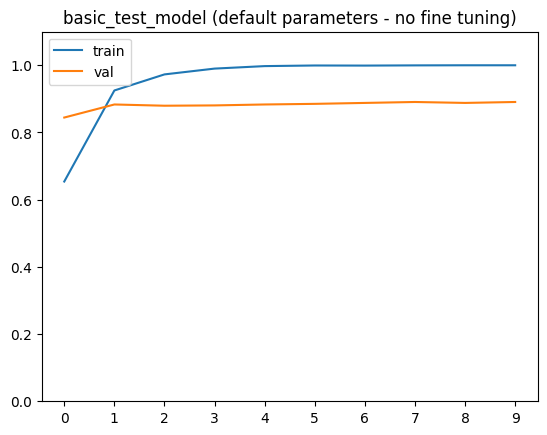

In [66]:
plt.plot(basic_test_model_history.history['accuracy'], label='train')
plt.plot(basic_test_model_history.history['val_accuracy'], label='val')
plt.title("basic_test_model (default parameters - no fine tuning)")
plt.xticks(np.arange(10))
plt.ylim((0,1.1))
plt.legend()

In [104]:
# We can see that the learning rate did not help, as 
# the accuracy did not grow very quickly; we will experiment on this later
# Also, the training set seems to have overtitted, so we will implement dropout
# and other techniques
# Also, we can see that around 5 epochs are enough to get a stable value
# for time constrains on the execution, that number of epochs will be used

**Validating prediction**

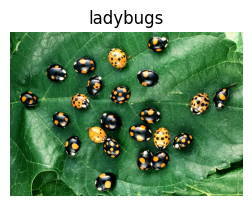

In [67]:
# sample img (full path defined in "Read and Resize" section)
sample_img = imread(sample_image_full_path)
plt.figure(figsize=(3, 3))
plt.imshow(sample_img)
plt.title(sample_image_label)
plt.axis('off')
plt.show()

In [68]:
encoded_classes = dict(zip(test_ds_small.class_indices.values(), test_ds_small.class_indices.keys()))

In [71]:
encoded_classes[0], encoded_classes[1], encoded_classes[2]

('antelope', 'badger', 'bat')

In [72]:
# With target_size =small
x = center_crop_and_resize(sample_img, image_size=SMALL_IMAGE_SIZE)
X = preprocess_input(x)
X = np.expand_dims(X, 0)
pred = basic_test_model.predict(X)

y_pred = np.argmax(pred, axis = 1)
predicted_class = y_pred
predicted_proba = np.asarray(tf.reduce_max(pred)).flatten()[0]
predicted_label = encoded_classes[y_pred[0]]
print("Predicted class: ", y_pred[0])
print("Predicted label: ",predicted_label)
print("Predicted proba: ", predicted_proba)

1/1 [==============================] - 2s 2s/step
Predicted class:  44
Predicted label:  ladybugs
Predicted proba:  0.98807263


In [73]:
# As we can see, the prediction is correct and with high probability
# However, the overall accruacry did not reach 90%
# We will try to improve this in the next steps

## Fine tunning

### Learning rate

In [75]:
scores = {}
num_epochs = 5
for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(f"Training with lr = {lr}")

    tmp_model = extend_model_v1(img_size = SMALL_IMAGE_SIZE, learning_rate=lr)
    tmp_history = tmp_model.fit(train_ds_small, epochs=num_epochs, validation_data=val_ds_small)
    scores[lr] = tmp_history.history

    print()
    print()

Training with lr = 0.0001
Epoch 1/5
216/216 [==============================] - 98s 434ms/step - loss: 4.2138 - accuracy: 0.1235 - val_loss: 3.8484 - val_accuracy: 0.3370
Epoch 2/5
216/216 [==============================] - 94s 436ms/step - loss: 3.4219 - accuracy: 0.5435 - val_loss: 3.1723 - val_accuracy: 0.6139
Epoch 3/5
216/216 [==============================] - 96s 443ms/step - loss: 2.7238 - accuracy: 0.7343 - val_loss: 2.5857 - val_accuracy: 0.7204
Epoch 4/5
216/216 [==============================] - 113s 525ms/step - loss: 2.1420 - accuracy: 0.8105 - val_loss: 2.1128 - val_accuracy: 0.7722
Epoch 5/5
216/216 [==============================] - 122s 567ms/step - loss: 1.6870 - accuracy: 0.8531 - val_loss: 1.7470 - val_accuracy: 0.8000


Training with lr = 0.001
Epoch 1/5
216/216 [==============================] - 120s 497ms/step - loss: 2.1084 - accuracy: 0.6602 - val_loss: 0.8774 - val_accuracy: 0.8454
Epoch 2/5
216/216 [==============================] - 117s 542ms/step - loss: 0.4

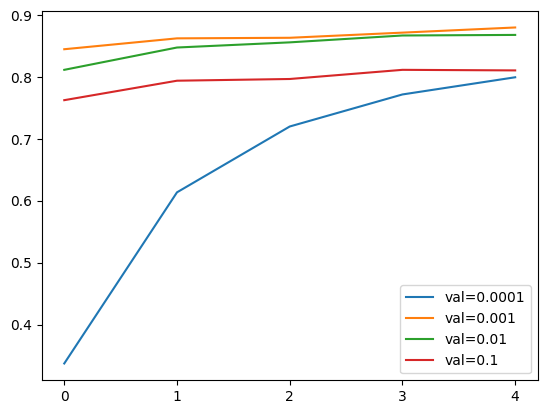

In [76]:
for lr, hist in scores.items():
    #plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(5))
plt.legend()

In [11]:
#Clearly, the best learning rate is 0.001
BEST_LEARNING_RATE = 0.001

### Inner layers  
* Adding one inner dense layer
* Experimenting with different sizes of inner layer

In [82]:
# model definition function with data augmentation
# (includes batch normalization, regularization, an inner layer,
# fine tuned learning rate and data augmentation)
def extend_model_v2(num_classes         = NUM_CLASSES,          # default to NUM_CLASSES
                    img_size            = SMALL_IMAGE_SIZE,     # default to SMALL_IMAGE_SIZE
                    learning_rate       = BEST_LEARNING_RATE,   # default to BEST_LEARNING_RATE
                    size_inner          = 100                   # default to 100
                ):
    # pre-trained model with the same img size as the specified
    base_model = EfficientNetB3(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size, img_size, 3)
    )

    # Freeze layers
    base_model.trainable = False

    #########################################
    inputs =        keras.layers.Input(shape=(img_size, img_size, 3), name = "inputLayer")
    base =          base_model(inputs, training=False)
    vectors =       keras.layers.GlobalAveragePooling2D()(base)
    # inner layer
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    raw_outputs =   keras.layers.Dense(num_classes)(inner)
    outputs =       keras.layers.Activation(
        # this returns probabilities
        activation="softmax", dtype=tf.float32, name='softMaxLayer' 
        )(raw_outputs)

    # final model architecture:
    model = keras.Model(inputs, outputs)

    #########################################
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=False)  # We will use softmax

    # compiled model
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

In [83]:
num_epochs = 5
scores = {}
for size in [10, 100, 1000]:
    print(size)

    model = extend_model_v2(size_inner=size)
    history = model.fit(train_ds_small, epochs=num_epochs, validation_data=val_ds_small)
    scores[size] = history.history

    print()
    print()

10
Epoch 1/5
216/216 [==============================] - 90s 381ms/step - loss: 4.0990 - accuracy: 0.1256 - val_loss: 3.5745 - val_accuracy: 0.2352
Epoch 2/5
216/216 [==============================] - 74s 341ms/step - loss: 2.8939 - accuracy: 0.4037 - val_loss: 2.5136 - val_accuracy: 0.4907
Epoch 3/5
216/216 [==============================] - 80s 369ms/step - loss: 1.9177 - accuracy: 0.6216 - val_loss: 1.8378 - val_accuracy: 0.6056
Epoch 4/5
216/216 [==============================] - 75s 346ms/step - loss: 1.3596 - accuracy: 0.7176 - val_loss: 1.4902 - val_accuracy: 0.6694
Epoch 5/5
216/216 [==============================] - 79s 367ms/step - loss: 1.0524 - accuracy: 0.7688 - val_loss: 1.2995 - val_accuracy: 0.7083


100
Epoch 1/5
216/216 [==============================] - 87s 378ms/step - loss: 2.2067 - accuracy: 0.5855 - val_loss: 0.7920 - val_accuracy: 0.8213
Epoch 2/5
216/216 [==============================] - 80s 372ms/step - loss: 0.3777 - accuracy: 0.9216 - val_loss: 0.5657 - val_

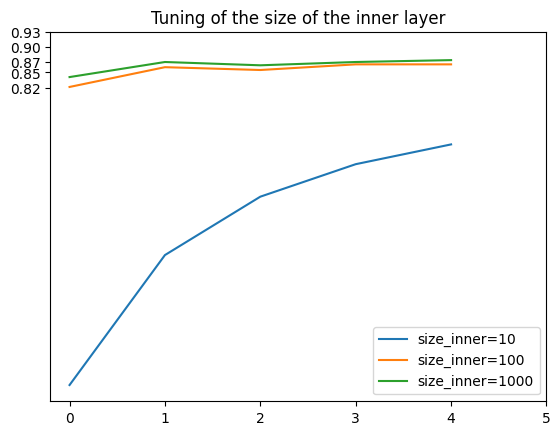

In [84]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('size_inner=%s' % size))
plt.xticks(np.arange(6))
plt.yticks([0.82, 0.85, 0.87, 0.9, 0.93])
plt.title("Tuning of the size of the inner layer")
plt.legend()

In [12]:
# There's no much of a difference in performance between 100 and 1000 layers
# we'll stick to 100
BEST_INNER_SIZE = 100

### Regularization (dropout)
* Regularizing by freezing a part of the network
* Adding dropout to our model
* Experimenting with different values

In [13]:
# model definition function with data augmentation
# (includes batch normalization, regularization, an inner layer,
# fine tuned learning rate and data augmentation)
def extend_model_v3(num_classes         = NUM_CLASSES,          # default to NUM_CLASSES
                    img_size            = SMALL_IMAGE_SIZE,     # default to SMALL_IMAGE_SIZE
                    learning_rate       = BEST_LEARNING_RATE,   # default to BEST_LEARNING_RATE
                    size_inner          = BEST_INNER_SIZE,      # default to BEST_INNER_SIZE
                    drop_rate           = 0.1                   # default to 0.1 until we know the best
                ):
    # pre-trained model with the same img size as the specified
    base_model = EfficientNetB3(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size, img_size, 3)
    )

    # Freeze layers
    base_model.trainable = False

    #########################################
    inputs =        keras.layers.Input(shape=(img_size, img_size, 3), name = "inputLayer")
    base =          base_model(inputs, training=False)
    vectors =       keras.layers.GlobalAveragePooling2D()(base)
    # inner layer
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    # dropout layer
    drop = keras.layers.Dropout(drop_rate)(inner)
    # outputs as raw numbers
    raw_outputs =   keras.layers.Dense(num_classes)(drop)
    # outputs as probabilities
    outputs =       keras.layers.Activation(
        # this returns probabilities
        activation="softmax", dtype=tf.float32, name='softMaxLayer' 
        )(raw_outputs)

    # final model architecture:
    model = keras.Model(inputs, outputs)

    #########################################
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=False)  # We will use softmax

    # compiled model
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

In [14]:
scores_dropout = {}
num_epochs = 6
for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)

    model = extend_model_v3(
        drop_rate=droprate # the rest of the parameters are already defaulted to the best found
    )

    history = model.fit(train_ds_small, epochs=num_epochs, validation_data=val_ds_small)
    scores_dropout[droprate] = history.history

    print()
    print()

0.0


Epoch 1/6


216/216 [==============================] - 110s 479ms/step - loss: 2.1704 - accuracy: 0.6009 - val_loss: 0.7785 - val_accuracy: 0.8370
Epoch 2/6
216/216 [==============================] - 74s 343ms/step - loss: 0.3686 - accuracy: 0.9222 - val_loss: 0.5694 - val_accuracy: 0.8556
Epoch 3/6
216/216 [==============================] - 83s 385ms/step - loss: 0.1364 - accuracy: 0.9806 - val_loss: 0.5104 - val_accuracy: 0.8620
Epoch 4/6
216/216 [==============================] - 79s 368ms/step - loss: 0.0620 - accuracy: 0.9957 - val_loss: 0.4839 - val_accuracy: 0.8731
Epoch 5/6
216/216 [==============================] - 70s 322ms/step - loss: 0.0317 - accuracy: 0.9994 - val_loss: 0.4686 - val_accuracy: 0.8704
Epoch 6/6
216/216 [==============================] - 74s 343ms/step - loss: 0.0211 - accuracy: 0.9991 - val_loss: 0.4610 - val_accuracy: 0.8759


0.2
Epoch 1/6
216/216 [==============================] - 80s 338ms/step - loss: 2.4333 - accuracy: 0.5367 - val_loss: 0.8678 

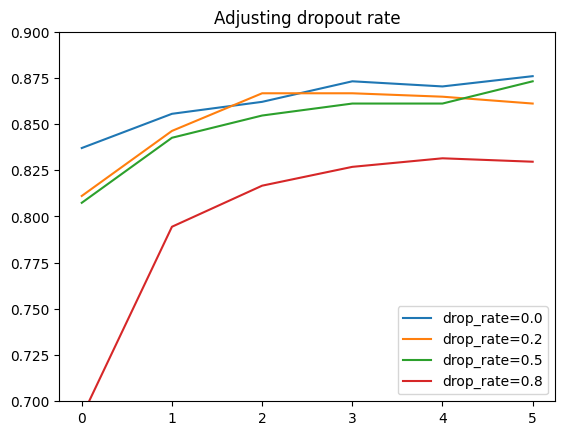

In [16]:
for droprate, hist in scores_dropout.items():
    plt.plot(hist['val_accuracy'], label=('drop_rate=%s' % droprate))

plt.ylim(0.7, 0.9)
plt.title("Adjusting dropout rate")
plt.legend()

In [17]:
# As we can see, adding drop_rate does not really improve the accuracy
# Still not the best performance, but this is in part due to the training
# done in a smaller dataset (img_size = (150,150))
# We will stick to a drop rate of 0.25
BEST_DROP_RATE = 0.25

### Batch normalization

In [18]:
# model definition function with data augmentation
# (includes batch normalization, regularization, an inner layer,
# fine tuned learning rate and data augmentation)
def extend_model_v4(num_classes         = NUM_CLASSES,          # default to NUM_CLASSES
                    img_size            = SMALL_IMAGE_SIZE,     # default to SMALL_IMAGE_SIZE
                    learning_rate       = BEST_LEARNING_RATE,   # default to BEST_LEARNING_RATE
                    size_inner          = BEST_INNER_SIZE,      # default to BEST_INNER_SIZE
                    drop_rate           = BEST_DROP_RATE,       # default to BEST_DROP_RATE
                    batch_normalization = True                  # default to true
                ):
    # pre-trained model with the same img size as the specified
    base_model = EfficientNetB3(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size, img_size, 3)
    )

    # Freeze layers
    base_model.trainable = False

    #########################################
    inputs =        keras.layers.Input(shape=(img_size, img_size, 3), name = "inputLayer")
    base =          base_model(inputs, training=False)
    vectors =       keras.layers.GlobalAveragePooling2D()(base)
    # inner layer
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    # batch normalizaiton
    if(batch_normalization):
        batch_normalized = keras.layers.BatchNormalization()(inner)
        # dropout layer
        drop = keras.layers.Dropout(drop_rate)(batch_normalized)
    else:
        # dropout layer
        drop = keras.layers.Dropout(drop_rate)(inner)
        
    # outputs as raw numbers
    raw_outputs =   keras.layers.Dense(num_classes)(drop)
    # outputs as probabilities
    outputs =       keras.layers.Activation(
        # this returns probabilities
        activation="softmax", dtype=tf.float32, name='softMaxLayer' 
        )(raw_outputs)

    # final model architecture:
    model = keras.Model(inputs, outputs)

    #########################################
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=False)  # We will use softmax

    # compiled model
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

In [20]:
# Adding batch normalization
num_epochs = 10
model_normalized = extend_model_v4(
        batch_normalization=True # the rest of the parameters are already defaulted to the best found
    )

history_normalized_true = model_normalized.fit(train_ds_small, epochs=num_epochs, validation_data=val_ds_small)

Epoch 1/10
216/216 [==============================] - 93s 397ms/step - loss: 2.2888 - accuracy: 0.5296 - val_loss: 1.1532 - val_accuracy: 0.8176
Epoch 2/10
216/216 [==============================] - 83s 384ms/step - loss: 0.6638 - accuracy: 0.8750 - val_loss: 0.6395 - val_accuracy: 0.8463
Epoch 3/10
216/216 [==============================] - 74s 342ms/step - loss: 0.3070 - accuracy: 0.9543 - val_loss: 0.5481 - val_accuracy: 0.8574
Epoch 4/10
216/216 [==============================] - 74s 341ms/step - loss: 0.1637 - accuracy: 0.9756 - val_loss: 0.5435 - val_accuracy: 0.8611
Epoch 5/10
216/216 [==============================] - 91s 422ms/step - loss: 0.0909 - accuracy: 0.9904 - val_loss: 0.5232 - val_accuracy: 0.8657
Epoch 6/10
216/216 [==============================] - 73s 338ms/step - loss: 0.0624 - accuracy: 0.9926 - val_loss: 0.5196 - val_accuracy: 0.8657
Epoch 7/10
216/216 [==============================] - 80s 373ms/step - loss: 0.0440 - accuracy: 0.9969 - val_loss: 0.5208 - val_ac

In [21]:
# With no batch normalization
num_epochs = 10
model_no_normalized = extend_model_v4(
        batch_normalization=False # the rest of the parameters are already defaulted to the best found
    )

history_normalized_false = model_no_normalized.fit(train_ds_small, epochs=num_epochs, validation_data=val_ds_small)

Epoch 1/10
216/216 [==============================] - 78s 327ms/step - loss: 2.4974 - accuracy: 0.5204 - val_loss: 0.9310 - val_accuracy: 0.8028
Epoch 2/10
216/216 [==============================] - 77s 356ms/step - loss: 0.6084 - accuracy: 0.8608 - val_loss: 0.6151 - val_accuracy: 0.8389
Epoch 3/10
216/216 [==============================] - 75s 346ms/step - loss: 0.3303 - accuracy: 0.9207 - val_loss: 0.5621 - val_accuracy: 0.8454
Epoch 4/10
216/216 [==============================] - 71s 331ms/step - loss: 0.1889 - accuracy: 0.9623 - val_loss: 0.5339 - val_accuracy: 0.8583
Epoch 5/10
216/216 [==============================] - 66s 308ms/step - loss: 0.1290 - accuracy: 0.9772 - val_loss: 0.4927 - val_accuracy: 0.8667
Epoch 6/10
216/216 [==============================] - 69s 319ms/step - loss: 0.0923 - accuracy: 0.9836 - val_loss: 0.4883 - val_accuracy: 0.8657
Epoch 7/10
216/216 [==============================] - 77s 356ms/step - loss: 0.0692 - accuracy: 0.9883 - val_loss: 0.4865 - val_ac

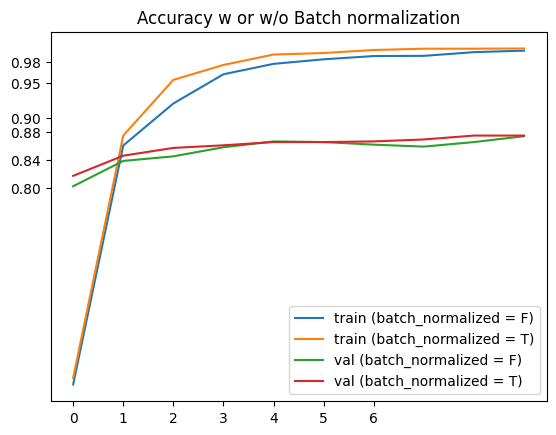

In [24]:
## Model performance
plt.plot(history_normalized_false.history['accuracy'], label='train (batch_normalized = F)')
plt.plot(history_normalized_true.history['accuracy'], label='train (batch_normalized = T)')
plt.plot(history_normalized_false.history['val_accuracy'], label='val (batch_normalized = F)')
plt.plot(history_normalized_true.history['val_accuracy'], label='val (batch_normalized = T)')
plt.xticks(np.arange(7))
plt.yticks([0.8, 0.84, 0.88, 0.9, 0.95,0.98])
plt.title("Accuracy w or w/o Batch normalization")
plt.legend()

In [25]:
# As we can see, there was a slight improvement adding batch normalization, 
# Though not that big of a difference
# Next, we can train on a larger model (increase image_size)

### Checkpointing

In [ ]:
# Up to this point, we already have the best variables for training

In [26]:
# save with checkpointing
checkpoint_small = keras.callbacks.ModelCheckpoint(
    'EfficientNetB3_small_{epoch:02d}_{val_accuracy:.3f}.keras', # .h5 is legacy
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [27]:
num_epochs = 20
model_small = extend_model_v4(
    # Though all the parameters are defaulted to the best, include them here for clarity
    num_classes= NUM_CLASSES,
    img_size=SMALL_IMAGE_SIZE,
    learning_rate=BEST_LEARNING_RATE,
    drop_rate=BEST_DROP_RATE,
    batch_normalization=True
)

history_small = model_small.fit(
    train_ds_small,
    epochs=num_epochs,
    validation_data=val_ds_small,
    callbacks=[checkpoint_small]
)

Epoch 1/20
216/216 [==============================] - 99s 401ms/step - loss: 2.2681 - accuracy: 0.5340 - val_loss: 1.1198 - val_accuracy: 0.8093
Epoch 2/20
216/216 [==============================] - 116s 535ms/step - loss: 0.6476 - accuracy: 0.8787 - val_loss: 0.6420 - val_accuracy: 0.8556
Epoch 3/20
216/216 [==============================] - 78s 362ms/step - loss: 0.2946 - accuracy: 0.9512 - val_loss: 0.5445 - val_accuracy: 0.8694
Epoch 4/20
216/216 [==============================] - 75s 349ms/step - loss: 0.1575 - accuracy: 0.9778 - val_loss: 0.5156 - val_accuracy: 0.8722
Epoch 5/20
216/216 [==============================] - 77s 359ms/step - loss: 0.0904 - accuracy: 0.9898 - val_loss: 0.5176 - val_accuracy: 0.8722
Epoch 6/20
216/216 [==============================] - 74s 343ms/step - loss: 0.0571 - accuracy: 0.9963 - val_loss: 0.5081 - val_accuracy: 0.8704
Epoch 7/20
216/216 [==============================] - 73s 339ms/step - loss: 0.0441 - accuracy: 0.9966 - val_loss: 0.5268 - val_a

In [28]:
# The best model with the best parameters has been saved

# Training on a larger dataset  
We will now train the model with the best parameters on a larger dataset

## Larger image generators

In [29]:
%%time
BATCH_SIZE = 15
IMAGE_SIZE = (LARGE_IMAGE_SIZE, LARGE_IMAGE_SIZE)

gen_large = ImageDataGenerator(preprocessing_function = preprocess_input)

# data is in the dataframes
train_ds_large = gen_large.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=0,
)

val_ds_large = gen_large.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds_large = gen_large.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 3240 validated image filenames belonging to 90 classes.
Found 1080 validated image filenames belonging to 90 classes.
Found 1080 validated image filenames belonging to 90 classes.
CPU times: total: 484 ms
Wall time: 475 ms


## Model definition, training and checkpointing

In [30]:
# save with checkpointing
checkpoint_large = keras.callbacks.ModelCheckpoint(
    'EfficientNetB3_large_{epoch:02d}_{val_accuracy:.3f}.keras', # .h5 is legacy
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [31]:
num_epochs = 20
model_large = extend_model_v4(
    # Though all the parameters are defaulted to the best, include them here for clarity
    num_classes         = NUM_CLASSES,
    img_size            = LARGE_IMAGE_SIZE,
    learning_rate       = BEST_LEARNING_RATE,
    drop_rate           = BEST_DROP_RATE,
    batch_normalization = True
)

history_large = model_large.fit(
    train_ds_large,
    epochs=num_epochs,
    validation_data=val_ds_large,
    callbacks=[checkpoint_large]
)

Epoch 1/20
216/216 [==============================] - 150s 660ms/step - loss: 1.8745 - accuracy: 0.6235 - val_loss: 0.8428 - val_accuracy: 0.8713
Epoch 2/20
216/216 [==============================] - 134s 621ms/step - loss: 0.4461 - accuracy: 0.9160 - val_loss: 0.3792 - val_accuracy: 0.9102
Epoch 3/20
216/216 [==============================] - 128s 594ms/step - loss: 0.1881 - accuracy: 0.9759 - val_loss: 0.3146 - val_accuracy: 0.9130
Epoch 4/20
216/216 [==============================] - 131s 606ms/step - loss: 0.1015 - accuracy: 0.9849 - val_loss: 0.2950 - val_accuracy: 0.9176
Epoch 5/20
216/216 [==============================] - 129s 599ms/step - loss: 0.0571 - accuracy: 0.9954 - val_loss: 0.2932 - val_accuracy: 0.9231
Epoch 6/20
216/216 [==============================] - 129s 596ms/step - loss: 0.0440 - accuracy: 0.9938 - val_loss: 0.2976 - val_accuracy: 0.9130
Epoch 7/20
216/216 [==============================] - 131s 608ms/step - loss: 0.0310 - accuracy: 0.9963 - val_loss: 0.2812 -

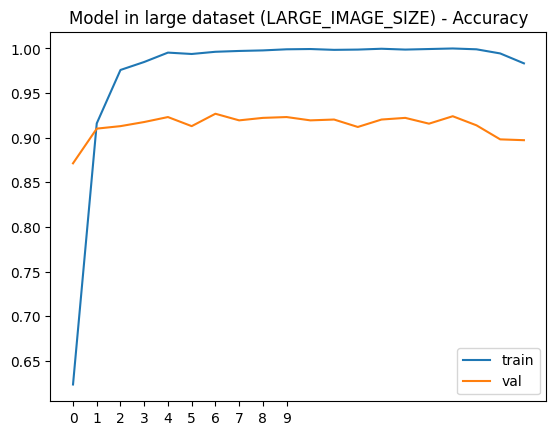

In [32]:
## Model performance
plt.plot(history_large.history['accuracy'], label='train')
plt.plot(history_large.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.title("Model in large dataset (LARGE_IMAGE_SIZE) - Accuracy")
plt.legend()

## Small vs Large models

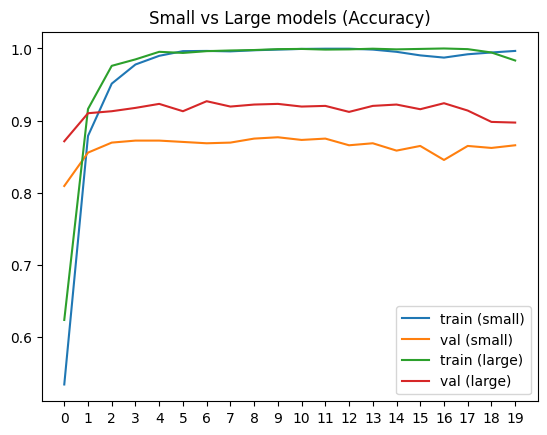

In [33]:
# We will check if the is a difference between both models
## Model performance
plt.plot(history_small.history['accuracy'], label='train (small)')
plt.plot(history_small.history['val_accuracy'], label='val (small)')
plt.plot(history_large.history['accuracy'], label='train (large)')
plt.plot(history_large.history['val_accuracy'], label='val (large)')
plt.xticks(np.arange(20))
plt.title("Small vs Large models (Accuracy)")
plt.legend()

In [34]:
# As wee can see, there is a significant difference in the performace
# between the two approaches, so we will stick to the large model

# Data augmentation  

## Augmentation

In [35]:
# We can add data augmentation in two ways: 
# 1. In the data generators
# 2. As a set of sequential layers before the main model

**Augmentation in the data generators**  
In this case, we will just add horizontal flipping, random zoom and rangom rotation, due to the nature of the images

In [36]:
%%time

BATCH_SIZE = 15
IMAGE_SIZE = (LARGE_IMAGE_SIZE, LARGE_IMAGE_SIZE)

gen_augmentation = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    # Data augmentation
    horizontal_flip=True,
    rotation_range = 15,
    zoom_range = 0.15
    )

# data is in the dataframes
train_ds_large_augmented = gen_augmentation.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=0,
)

val_ds_large_augmented = gen_augmentation.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds_large_augmented = gen_augmentation.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 3240 validated image filenames belonging to 90 classes.
Found 1080 validated image filenames belonging to 90 classes.
Found 1080 validated image filenames belonging to 90 classes.
CPU times: total: 359 ms
Wall time: 362 ms


**Augmentation as a sequential submodel**  
In this part, we will add additional augmentation as a sequential submodel that will be placed between the input layer and the rest of the layers of the main model.

In [37]:
# We will add some steps to augment the data from the original dataset
# this set of layers can be added just after the input layer or omitted in the final model
num_classes = NUM_CLASSES
augmentation_layers = keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip("horizontal"), #flip to both sides
  keras.layers.experimental.preprocessing.RandomRotation(0.15),
  keras.layers.experimental.preprocessing.RandomZoom(0.15),
  keras.layers.experimental.preprocessing.RandomContrast(0.15),
], name='augmentationLayer')

## Augmented Model definition

In [38]:
# We will use model_v4 in this case and just test on augmented datasets for time reasons
model_large_augmentedDataset = extend_model_v4(
    # Though all the parameters are defaulted to the best, include them here for clarity
    num_classes         = NUM_CLASSES,
    img_size            = LARGE_IMAGE_SIZE,
    learning_rate       = BEST_LEARNING_RATE,
    drop_rate           = BEST_DROP_RATE,
    batch_normalization = True
)

## **Training and checkpointing**

In [39]:
# save with checkpointing
checkpoint_large_augmentedDataset = keras.callbacks.ModelCheckpoint(
    'EfficientNetB3_large_augmentedDataset_{epoch:02d}_{val_accuracy:.3f}.keras', # .h5 is legacy
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [40]:
num_epochs = 10
history_large_augmented = model_large.fit(
    train_ds_large_augmented,
    epochs=num_epochs,
    validation_data=val_ds_large_augmented,
    callbacks=[checkpoint_large_augmentedDataset]
)

Epoch 1/10
216/216 [==============================] - 156s 722ms/step - loss: 0.2409 - accuracy: 0.9321 - val_loss: 0.4771 - val_accuracy: 0.8833
Epoch 2/10
216/216 [==============================] - 155s 720ms/step - loss: 0.1073 - accuracy: 0.9688 - val_loss: 0.4143 - val_accuracy: 0.8917
Epoch 3/10
216/216 [==============================] - 133s 615ms/step - loss: 0.0608 - accuracy: 0.9818 - val_loss: 0.4257 - val_accuracy: 0.8991
Epoch 4/10
216/216 [==============================] - 132s 610ms/step - loss: 0.0438 - accuracy: 0.9898 - val_loss: 0.3917 - val_accuracy: 0.9056
Epoch 5/10
216/216 [==============================] - 139s 644ms/step - loss: 0.0406 - accuracy: 0.9907 - val_loss: 0.4320 - val_accuracy: 0.8981
Epoch 6/10
216/216 [==============================] - 136s 627ms/step - loss: 0.0398 - accuracy: 0.9877 - val_loss: 0.4844 - val_accuracy: 0.8889
Epoch 7/10
216/216 [==============================] - 138s 639ms/step - loss: 0.0283 - accuracy: 0.9907 - val_loss: 0.4147 -

## **Augmented vs no-augmentation**

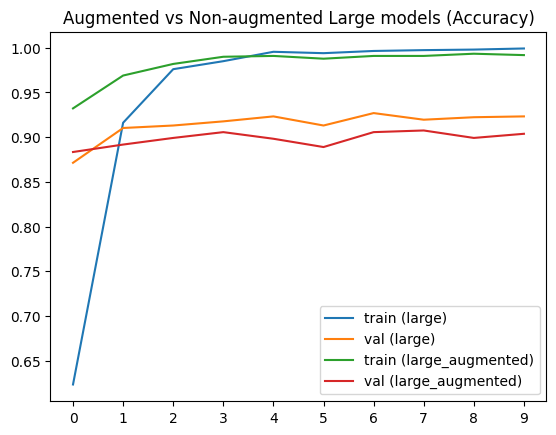

In [42]:
# We will check if the is a difference between both models
## Model performance
plt.plot(history_large.history['accuracy'][:10], label='train (large)')
plt.plot(history_large.history['val_accuracy'][:10], label='val (large)')
plt.plot(history_large_augmented.history['accuracy'], label='train (large_augmented)')
plt.plot(history_large_augmented.history['val_accuracy'], label='val (large_augmented)')
plt.xticks(np.arange(10))
plt.title("Augmented vs Non-augmented Large models (Accuracy)")
plt.legend()

In [43]:
# As we can see, the model did not improve and was below 90%
# So we are going to use the model without augmentation

# **Model evaluation (best models)**

## Accuracy

**Model with no augmentation**

In [44]:
# model selection
best_EfficientNetB3_model_no_augmentation = keras.models.load_model('EfficientNetB3_large_07_0.927.keras')
best_EfficientNetB3_model_augmentation = keras.models.load_model('EfficientNetB3_large_augmentedDataset_08_0.907.keras')

In [45]:
results_best_no_augmentation = best_EfficientNetB3_model_no_augmentation.evaluate(test_ds_large)
results_best_augmentation = best_EfficientNetB3_model_augmentation.evaluate(test_ds_large_augmented)

print("NON-AUGMENTED MODEL")
print("    Test Loss: {:.5f}".format(results_best_no_augmentation[0]))
print("Test Accuracy: {:.2f} %".format(results_best_no_augmentation[1] * 100))

print("\nAUGMENTED MODEL")
print("    Test Loss: {:.5f}".format(results_best_augmentation[0]))
print("Test Accuracy: {:.2f} %".format(results_best_augmentation[1] * 100))

72/72 [==============================] - 45s 586ms/step - loss: 0.4203 - accuracy: 0.9056
NON-AUGMENTED MODEL
    Test Loss: 0.30626
Test Accuracy: 92.13 %

AUGMENTED MODEL
    Test Loss: 0.42033
Test Accuracy: 90.56 %


In [46]:
# As we can see, the accuracy in the test set was fairly close to the one obtained
# in training for both models.

## F1 and classification report

In [47]:
# We will test these metrics using the non-augmented model only

In [48]:
y_true = test_ds_large.classes
y_pred = np.argmax(best_EfficientNetB3_model_no_augmentation.predict(test_ds_large), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_ds_large.class_indices.keys()))

72/72 [==============================] - 48s 627ms/step
F1 Score: 0.9192854918334239
                precision    recall  f1-score   support

      antelope       1.00      0.80      0.89        10
        badger       1.00      0.90      0.95        10
           bat       0.78      0.88      0.82         8
          bear       1.00      1.00      1.00        13
           bee       1.00      0.86      0.92        14
        beetle       0.89      1.00      0.94         8
         bison       1.00      1.00      1.00         9
          boar       0.79      1.00      0.88        11
     butterfly       0.95      0.78      0.86        23
           cat       0.91      0.83      0.87        12
   caterpillar       0.91      0.77      0.83        13
    chimpanzee       0.91      0.91      0.91        11
     cockroach       1.00      1.00      1.00         7
           cow       0.80      0.73      0.76        11
        coyote       1.00      0.95      0.97        20
          crab    

# **Using the Model**

In [49]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img  # pip install pillow, then restart the kernel


from efficientnet.tfkeras import center_crop_and_resize, preprocess_input

## Loading the model

In [50]:
# load a model previously saved:
best_EfficientNetB3_model = keras.models.load_model('EfficientNetB3_large_07_0.927.keras')

In [51]:
best_EfficientNetB3_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 efficientnet-b3 (Functiona  (None, 7, 7, 1536)        10783528  
 l)                                                              
                                                                 
 global_average_pooling2d_8  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_16 (Dense)            (None, 100)               153700    
                                                                 
 batch_normalization_3 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                           

## Getting predictions

In [52]:
test_sample_animals = [
    "./img/animals/duck/72decb40db.jpg",
    "./img/animals/crow/03c7cea31f.jpg",
    "./img/animals/possum/3f9a0f744a.jpg",
    "./img/animals/bison/4d50fcf8a7.jpg",
    "./img/animals/pelecaniformes/105d4649cc.jpg",
    "./img/animals/deer/66c58b431f.jpg"
]

In [59]:
encoded_classes = dict(zip(test_ds_large.class_indices.values(), test_ds_large.class_indices.keys()))

In [71]:
encoded_classes


{0: 'antelope',
 1: 'badger',
 2: 'bat',
 3: 'bear',
 4: 'bee',
 5: 'beetle',
 6: 'bison',
 7: 'boar',
 8: 'butterfly',
 9: 'cat',
 10: 'caterpillar',
 11: 'chimpanzee',
 12: 'cockroach',
 13: 'cow',
 14: 'coyote',
 15: 'crab',
 16: 'crow',
 17: 'deer',
 18: 'dog',
 19: 'dolphin',
 20: 'donkey',
 21: 'dragonfly',
 22: 'duck',
 23: 'eagle',
 24: 'elephant',
 25: 'flamingo',
 26: 'fly',
 27: 'fox',
 28: 'goat',
 29: 'goldfish',
 30: 'goose',
 31: 'gorilla',
 32: 'grasshopper',
 33: 'hamster',
 34: 'hare',
 35: 'hedgehog',
 36: 'hippopotamus',
 37: 'hornbill',
 38: 'horse',
 39: 'hummingbird',
 40: 'hyena',
 41: 'jellyfish',
 42: 'kangaroo',
 43: 'koala',
 44: 'ladybugs',
 45: 'leopard',
 46: 'lion',
 47: 'lizard',
 48: 'lobster',
 49: 'mosquito',
 50: 'moth',
 51: 'mouse',
 52: 'octopus',
 53: 'okapi',
 54: 'orangutan',
 55: 'otter',
 56: 'owl',
 57: 'ox',
 58: 'oyster',
 59: 'panda',
 60: 'parrot',
 61: 'pelecaniformes',
 62: 'penguin',
 63: 'pig',
 64: 'pigeon',
 65: 'porcupine',
 66: 

In [74]:
hard_coded_classes =\
{0: 'antelope',
 1: 'badger',
 2: 'bat',
 3: 'bear',
 4: 'bee',
 5: 'beetle',
 6: 'bison',
 7: 'boar',
 8: 'butterfly',
 9: 'cat',
 10: 'caterpillar',
 11: 'chimpanzee',
 12: 'cockroach',
 13: 'cow',
 14: 'coyote',
 15: 'crab',
 16: 'crow',
 17: 'deer',
 18: 'dog',
 19: 'dolphin',
 20: 'donkey',
 21: 'dragonfly',
 22: 'duck',
 23: 'eagle',
 24: 'elephant',
 25: 'flamingo',
 26: 'fly',
 27: 'fox',
 28: 'goat',
 29: 'goldfish',
 30: 'goose',
 31: 'gorilla',
 32: 'grasshopper',
 33: 'hamster',
 34: 'hare',
 35: 'hedgehog',
 36: 'hippopotamus',
 37: 'hornbill',
 38: 'horse',
 39: 'hummingbird',
 40: 'hyena',
 41: 'jellyfish',
 42: 'kangaroo',
 43: 'koala',
 44: 'ladybugs',
 45: 'leopard',
 46: 'lion',
 47: 'lizard',
 48: 'lobster',
 49: 'mosquito',
 50: 'moth',
 51: 'mouse',
 52: 'octopus',
 53: 'okapi',
 54: 'orangutan',
 55: 'otter',
 56: 'owl',
 57: 'ox',
 58: 'oyster',
 59: 'panda',
 60: 'parrot',
 61: 'pelecaniformes',
 62: 'penguin',
 63: 'pig',
 64: 'pigeon',
 65: 'porcupine',
 66: 'possum',
 67: 'raccoon',
 68: 'rat',
 69: 'reindeer',
 70: 'rhinoceros',
 71: 'sandpiper',
 72: 'seahorse',
 73: 'seal',
 74: 'shark',
 75: 'sheep',
 76: 'snake',
 77: 'sparrow',
 78: 'squid',
 79: 'squirrel',
 80: 'starfish',
 81: 'swan',
 82: 'tiger',
 83: 'turkey',
 84: 'turtle',
 85: 'whale',
 86: 'wolf',
 87: 'wombat',
 88: 'woodpecker',
 89: 'zebra'
 }

In [77]:
# saving the classes for later use:
import pickle

with open('encoded_classes.pkl', 'wb') as outp:
    pickle.dump(encoded_classes, outp, pickle.HIGHEST_PROTOCOL)

In [78]:
# test loading the classes:
with open('encoded_classes.pkl', 'rb') as inp:
    encoded_classses_loaded = pickle.load(inp)

encoded_classses_loaded

{0: 'antelope',
 1: 'badger',
 2: 'bat',
 3: 'bear',
 4: 'bee',
 5: 'beetle',
 6: 'bison',
 7: 'boar',
 8: 'butterfly',
 9: 'cat',
 10: 'caterpillar',
 11: 'chimpanzee',
 12: 'cockroach',
 13: 'cow',
 14: 'coyote',
 15: 'crab',
 16: 'crow',
 17: 'deer',
 18: 'dog',
 19: 'dolphin',
 20: 'donkey',
 21: 'dragonfly',
 22: 'duck',
 23: 'eagle',
 24: 'elephant',
 25: 'flamingo',
 26: 'fly',
 27: 'fox',
 28: 'goat',
 29: 'goldfish',
 30: 'goose',
 31: 'gorilla',
 32: 'grasshopper',
 33: 'hamster',
 34: 'hare',
 35: 'hedgehog',
 36: 'hippopotamus',
 37: 'hornbill',
 38: 'horse',
 39: 'hummingbird',
 40: 'hyena',
 41: 'jellyfish',
 42: 'kangaroo',
 43: 'koala',
 44: 'ladybugs',
 45: 'leopard',
 46: 'lion',
 47: 'lizard',
 48: 'lobster',
 49: 'mosquito',
 50: 'moth',
 51: 'mouse',
 52: 'octopus',
 53: 'okapi',
 54: 'orangutan',
 55: 'otter',
 56: 'owl',
 57: 'ox',
 58: 'oyster',
 59: 'panda',
 60: 'parrot',
 61: 'pelecaniformes',
 62: 'penguin',
 63: 'pig',
 64: 'pigeon',
 65: 'porcupine',
 66: 

(1500, 1000, 3)
(224, 224, 3)
	 (1, 224, 224, 3)
1/1 [==============================] - 0s 185ms/step
Predicted class:  22
Predicted label:  duck
Predicted proba:  0.9989586
(184, 274, 3)
(224, 224, 3)
	 (1, 224, 224, 3)
1/1 [==============================] - 0s 169ms/step
Predicted class:  16
Predicted label:  crow
Predicted proba:  0.9969054
(600, 900, 3)
(224, 224, 3)
	 (1, 224, 224, 3)
1/1 [==============================] - 0s 174ms/step
Predicted class:  66
Predicted label:  possum
Predicted proba:  0.8718428
(675, 1200, 3)
(224, 224, 3)
	 (1, 224, 224, 3)
1/1 [==============================] - 0s 171ms/step
Predicted class:  6
Predicted label:  bison
Predicted proba:  0.98868936
(360, 480, 3)
(224, 224, 3)
	 (1, 224, 224, 3)
1/1 [==============================] - 0s 144ms/step
Predicted class:  61
Predicted label:  pelecaniformes
Predicted proba:  0.99506265
(168, 300, 3)
(224, 224, 3)
	 (1, 224, 224, 3)
1/1 [==============================] - 0s 166ms/step
Predicted class:  17
Pr

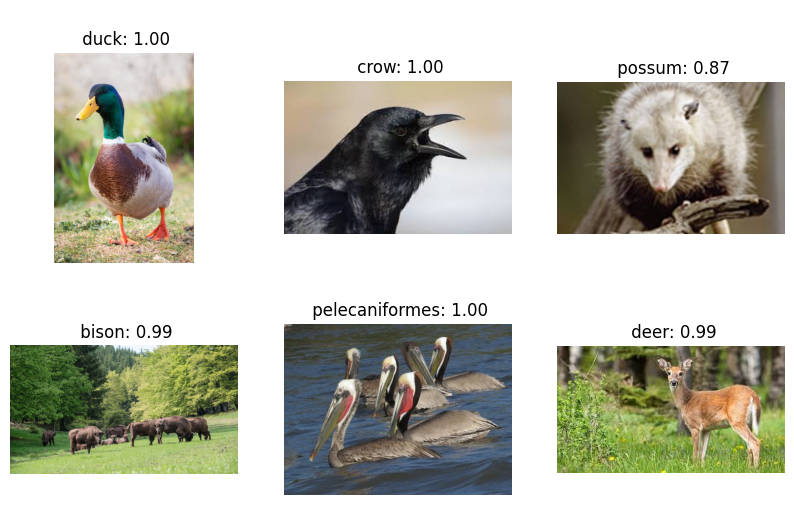

In [60]:

plt.figure(figsize=(10, 6))
for i, sample_path in zip(np.arange(len(test_sample_animals)), test_sample_animals):
    plt.subplot(2,3,i+1)
    test_sample_img = load_img(sample_path)
    
    x = np.array(test_sample_img)
    print(x.shape)
    x = center_crop_and_resize(x, image_size=LARGE_IMAGE_SIZE)
    print(x.shape)
    X = preprocess_input(x)
    X = np.expand_dims(X, 0) # expand dimensions
    #X = np.array([X])  # expand dimensions
    
    print("\t", X.shape)
    pred = best_EfficientNetB3_model.predict(X)
    y_pred = np.argmax(pred, axis = 1)
    predicted_class = y_pred
    predicted_proba = np.asarray(tf.reduce_max(pred)).flatten()[0]
    predicted_label = encoded_classes[y_pred[0]]
    print("Predicted class: ", y_pred[0])
    print("Predicted label: ",predicted_label)
    print("Predicted proba: ", predicted_proba)
    
    plt.imshow(test_sample_img)
    plt.title(f"\n {predicted_label}: {predicted_proba:.2f}")
    plt.axis('off')
plt.show()

## **Completely random and difficult images**  


In [69]:
test_sample_animals = [
    "./img/1447858661804.jpeg",
    "./img/African Painted Dogs 0187 - Grahm S. Jones, Columbus Zoo and Aquarium.jpg",
    "./img/quokka.jpg",
    "./img/bat.jpg",
    "./img/bat2.jpg",
    "./img/zebra_web.jpg"
]

(411, 616, 3)
(224, 224, 3)
	 (1, 224, 224, 3)
1/1 [==============================] - 0s 130ms/step
Predicted class:  8
Predicted label:  butterfly
Predicted proba:  0.9037682
(600, 600, 3)
(224, 224, 3)
	 (1, 224, 224, 3)
1/1 [==============================] - 0s 148ms/step
Predicted class:  40
Predicted label:  hyena
Predicted proba:  0.8346098
(897, 720, 3)
(224, 224, 3)
	 (1, 224, 224, 3)
1/1 [==============================] - 0s 127ms/step
Predicted class:  67
Predicted label:  raccoon
Predicted proba:  0.5825243
(1260, 2508, 3)
(224, 224, 3)
	 (1, 224, 224, 3)
1/1 [==============================] - 0s 105ms/step
Predicted class:  51
Predicted label:  mouse
Predicted proba:  0.85703003
(960, 960, 3)
(224, 224, 3)
	 (1, 224, 224, 3)
1/1 [==============================] - 0s 123ms/step
Predicted class:  2
Predicted label:  bat
Predicted proba:  0.7186681
(1024, 1536, 3)
(224, 224, 3)
	 (1, 224, 224, 3)
1/1 [==============================] - 0s 125ms/step
Predicted class:  89
Predict

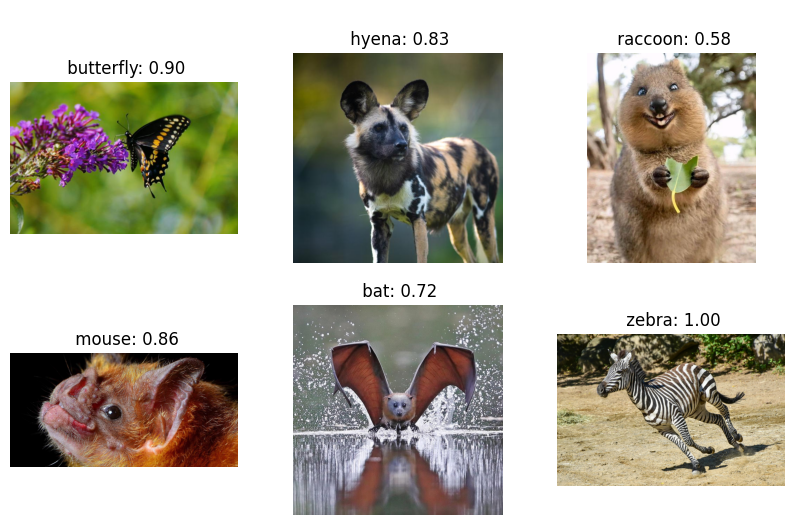

In [70]:

plt.figure(figsize=(10, 6))
for i, sample_path in zip(np.arange(len(test_sample_animals)), test_sample_animals):
    plt.subplot(2,3,i+1)
    test_sample_img = load_img(sample_path)
    
    x = np.array(test_sample_img)
    print(x.shape)
    x = center_crop_and_resize(x, image_size=LARGE_IMAGE_SIZE)
    print(x.shape)
    X = preprocess_input(x)
    X = np.expand_dims(X, 0) # expand dimensions
    #X = np.array([X])  # expand dimensions
    
    print("\t", X.shape)
    pred = best_EfficientNetB3_model.predict(X)
    y_pred = np.argmax(pred, axis = 1)
    predicted_class = y_pred
    predicted_proba = np.asarray(tf.reduce_max(pred)).flatten()[0]
    predicted_label = encoded_classes[y_pred[0]]
    print("Predicted class: ", y_pred[0])
    print("Predicted label: ",predicted_label)
    print("Predicted proba: ", predicted_proba)
    
    plt.imshow(test_sample_img)
    plt.title(f"\n {predicted_label}: {predicted_proba:.2f}")
    plt.axis('off')
plt.show()

# **Serving the model**  
In this section, evidence of the configuration, testing and production of the model is provided. 

# **Conclusion**  
We have developed an image multiclass classification model  based on the pretrained EfficientNetB3 model, to predict the class of 90 different animals.  With no modifications, that model achieves pretty good accuracy in any dataset.  

However, this is not particularly good in difficult images, but extending the model using Transfer learning, then an accuracy above 90% is achieved, and even on difficult images the accuracy is fairly good.  

From this project, the best take out is the Transfer Learning approach, which allows to reuse powerful models and adapt them to your needs.